In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [10]:
# Load the dataset
df = pd.read_excel('pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)

# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Convert the Date column to Date format
df['Date'] = pd.to_datetime(df['Date'].astype(str) + '01', format='%YM%m%d')


In [20]:
# Select specific columns
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]]

# Clean column names
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

# Remove the Date column for analysis
commodity_data = commodity.drop(columns='date')

# Column names to test
columns_to_test = commodity_data.columns
print(columns_to_test)

Index(['crude_brent', 'soybeans', 'gold', 'silver', 'urea_ee_bulk', 'maize'], dtype='object')


In [21]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [22]:
# Function for ADF Test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

# Loop through each column and perform the ADF test
for col in columns_to_test:
    p_value = adf_test(commodity_data[col])
    print(f"\nADF test result for column: {col}")
    print(f"P-value: {p_value}")
    
    # Check if the p-value is greater than 0.05 
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)


ADF test result for column: crude_brent
P-value: 0.5296165197702358

ADF test result for column: soybeans
P-value: 0.13530977427790403

ADF test result for column: gold
P-value: 0.9968394353612382

ADF test result for column: silver
P-value: 0.5835723787985763

ADF test result for column: urea_ee_bulk
P-value: 0.11301903181624678

ADF test result for column: maize
P-value: 0.12293380919376751


In [23]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")



Number of non-stationary columns: 6
Non-stationary columns: ['crude_brent', 'soybeans', 'gold', 'silver', 'urea_ee_bulk', 'maize']
Stationary columns: []


In [15]:
# Co-Integration Test (Johansen's Test)
# Determining the number of lags to use
model = VAR(commodity_data)
lags = model.select_order(maxlags=10)
lag_length = lags.aic

# Johansen Co-Integration Test
johansen_test = coint_johansen(commodity_data, det_order=0, k_ar_diff=lag_length)
print("\nJohansen Co-Integration Test Results:")
print("Trace Statistic:", johansen_test.lr1)
print("Critical Values (5%):", johansen_test.cvt[:, 1])
print("Max Eigen Statistic:", johansen_test.lr2)
print("Critical Values (5%):", johansen_test.cvm)


Johansen Co-Integration Test Results:
Trace Statistic: [176.46252708 104.96585715  67.84627098  37.39727549  16.60719811
   5.3013434 ]
Critical Values (5%): [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]
Max Eigen Statistic: [71.49666994 37.11958617 30.44899549 20.79007738 11.30585471  5.3013434 ]
Critical Values (5%): [[37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]



VECM Model Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation crude_brent
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.crude_brent      0.3213      0.038      8.373      0.000       0.246       0.397
L1.soybeans         0.0088      0.008      1.153      0.249      -0.006       0.024
L1.gold             0.0004      0.006      0.064      0.949      -0.012       0.013
L1.silver          -0.1046      0.162     -0.646      0.518      -0.422       0.213
L1.urea_ee_bulk    -0.0065      0.005     -1.344      0.179      -0.016       0.003
L1.maize            0.0223      0.017      1.281      0.200      -0.012       0.056
L2.crude_brent     -0.0467      0.041     -1.153      0.249      -0.126       0.033
L2.soybeans         0.0158      0.008      2.096      0.036       0.001       0.031
L2.gold            -0.0039      0.007     -0.579

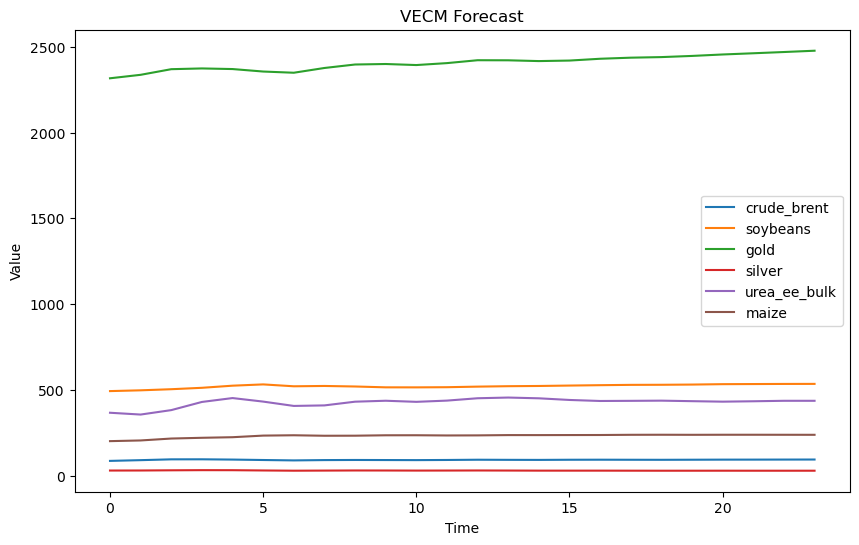

In [27]:
# Determine the number of co-integrating relationships (r) based on the test
r = 4

if r > 0:
    # If co-integration exists, estimate the VECM model
    from statsmodels.tsa.vector_ar.vecm import VECM
    vecm = VECM(commodity_data, k_ar_diff=lag_length, coint_rank=r)
    vecm_fit = vecm.fit()
    
    # Summary of the VECM model
    print("\nVECM Model Summary:")
    print(vecm_fit.summary())
    
    # Extracting the coefficients from the VECM model
    vecm_coefs = vecm_fit.beta
    print("\nVECM Coefficients:")
    print(vecm_coefs)
    
    # Forecasting using the VECM model
    forecast = vecm_fit.predict(steps=24)
    
    # Plotting the forecast
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(commodity_data.columns):
        plt.plot(forecast[:, i], label=col)
    plt.title('VECM Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    
else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = VAR(commodity_data)
    var_fit = var_model.fit(lag_length)
    
    # Summary of the VAR model
    print("\nVAR Model Summary:")
    print(var_fit.summary())
    
    # Granger causality test
    causality_results = var_fit.test_causality(causing=[var_model.endog_names[0]], caused=[var_model.endog_names[1]])
    print("\nGranger Causality Test Results:")
    print(causality_results.summary())
    
    # Forecasting using the VAR model
    forecast = var_fit.forecast(commodity_data.values[-lag_length:], steps=24)
    
    # Plotting the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(forecast)
    plt.title('VAR Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [26]:
print(forecast)

[[  85.63866613  492.63566265 2316.84321747   29.3522934   366.35037136
   200.82048143]
 [  89.8948206   497.1707843  2337.09453515   29.61557973  355.85495414
   204.81086668]
 [  94.65944983  503.62675514 2369.9158752    30.7273175   381.74107507
   215.99153976]
 [  94.87821302  511.84705344 2374.25802412   31.59319374  429.34014025
   220.33878623]
 [  93.28720768  524.21967656 2370.67207527   31.34870213  451.99760964
   223.72177649]
 [  90.75853979  531.6706142  2356.20298644   29.78899759  431.39375011
   233.1158371 ]
 [  88.44165607  520.69851881 2349.17610725   28.4458159   406.14656668
   235.07394177]
 [  90.32373305  522.56845502 2376.92142717   29.10464141  409.20398664
   232.22703814]
 [  91.00179207  519.48556652 2397.19183694   29.76558027  430.87516783
   232.5604158 ]
 [  90.56183087  514.55735677 2400.10319049   29.58082362  436.39683926
   234.96159073]
 [  90.13001486  514.39091386 2394.01562664   29.09879685  429.98581439
   235.16176782]
 [  90.99328771  515.